<a href="https://colab.research.google.com/github/hubingqian2011/Statistical-machine-learning/blob/main/word2vec_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import warnings
warnings.filterwarnings("ignore")

from torchtext.datasets import WikiText2, WikiText103

In [9]:
data_iter = WikiText2(split=("train"))
type(data_iter) # DataPipe that yields text from Wikipedia articles

torchdata.datapipes.iter.util.plain_text_reader.LineReaderIterDataPipe

In [27]:
i = 0
for label in data_iter:
  i = i + 1
  print(type(label))
  print(label)
  if i > 4:
    break

<class 'str'>
 

<class 'str'>
 = Robert <unk> = 

<class 'str'>
 

<class 'str'>
 Robert <unk> is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John <unk> in 2002 . In 2004 <unk> landed a role as " Craig " in the episode " Teddy 's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the <unk> <unk> Factory in London . He was directed by John <unk> and starred alongside Ben <unk> , Shane <unk> , Harry Kent , Fraser <unk> , Sophie Stanton and Dominic Hall . 

<class 'str'>
 In 2006 , <unk> starred alongside <unk> in the play <u

In [29]:
from torchtext.data import to_map_style_dataset
data_iter = to_map_style_dataset(data_iter)
data_iter

<torchtext.data.functional.to_map_style_dataset.<locals>._MapStyleDataset at 0x7f3683302b10>

In [31]:
i = 0
for label in data_iter:
  i = i + 1
  print(type(label))
  print(label)
  if i > 4:
    break

<class 'str'>
 

<class 'str'>
 = Robert <unk> = 

<class 'str'>
 

<class 'str'>
 Robert <unk> is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John <unk> in 2002 . In 2004 <unk> landed a role as " Craig " in the episode " Teddy 's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the <unk> <unk> Factory in London . He was directed by John <unk> and starred alongside Ben <unk> , Shane <unk> , Harry Kent , Fraser <unk> , Sophie Stanton and Dominic Hall . 

<class 'str'>
 In 2006 , <unk> starred alongside <unk> in the play <u

In [32]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english", language="en")

In [45]:
from torchtext.vocab import build_vocab_from_iterator

MIN_WORD_FREQUENCY = 50

vocab = build_vocab_from_iterator(
        map(tokenizer, data_iter),
        specials=["<unk>"],
        min_freq=MIN_WORD_FREQUENCY,
    )

# print(vocab.get_stoi())
vocab(['band']), vocab(['away']), vocab(['became'])

([313], [449], [115])

In [46]:
import torch

CBOW_N_WORDS = 4
SKIPGRAM_N_WORDS = 4
MAX_SEQUENCE_LENGTH = 256

def collate_cbow(batch, text_pipeline):
    """
    Collate_fn for CBOW model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.
    
    Context is represented as N=CBOW_N_WORDS past words 
    and N=CBOW_N_WORDS future words.
    
    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.
    
    Each element in `batch_input` is N=CBOW_N_WORDS*2 context words.
    Each element in `batch_output` is a middle word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < CBOW_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - CBOW_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + CBOW_N_WORDS * 2 + 1)]
            output = token_id_sequence.pop(CBOW_N_WORDS)
            input_ = token_id_sequence
            batch_input.append(input_)
            batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

def collate_skipgram(batch, text_pipeline):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.
    
    Context is represented as N=SKIPGRAM_N_WORDS past words 
    and N=SKIPGRAM_N_WORDS future words.
    
    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.
    
    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < SKIPGRAM_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            for output in outputs:
                batch_input.append(input_)
                batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

In [ ]:
from functools import partial
from torch.utils.data import DataLoader

shuffle = True
batch_size = 96

text_pipeline = lambda x: vocab(tokenizer(x))

model_name = "cbow"
if model_name == "cbow":
    collate_fn = collate_cbow
elif model_name == "skipgram":
    collate_fn = collate_skipgram
else:
    raise ValueError("Choose model from: cbow, skipgram")

dataloader = DataLoader(
    data_iter,
    batch_size=batch_size,
    shuffle=shuffle,
    collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
)
print(type(dataloader)) 
for i, batch_data in enumerate(dataloader, 1):
    pass
print(batch_data[0].shape)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [ ]:
x = torch.arange(12)
x = x.reshape(3,-1)
x

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [ ]:
torch.zeros((2,3,4))

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [ ]:
torch.ones((2,3,4))

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

有时我们想通过从某个特定的概率分布中随机采样来得到张量中每个元素的值。 例如，当我们构造数组来作为神经网络中的参数时，我们通常会随机初始化参数的值。 以下代码创建一个形状为（3,4）的张量。 其中的每个元素都从均值为0、标准差为1的标准高斯分布（正态分布）中随机采样。

In [ ]:
torch.randn(3,4)

tensor([[ 0.2012, -1.5811,  0.8862, -1.0943],
        [ 0.5519, -0.5277, -1.0233, -0.0810],
        [-0.7403,  0.1773,  1.8551,  0.3653]])

In [ ]:
torch.tensor([[2,1,4,3],[1,2,3,4]])

tensor([[2, 1, 4, 3],
        [1, 2, 3, 4]])

我们的兴趣不仅限于读取数据和写入数据。 我们想在这些数据上执行数学运算，其中最简单且最有用的操作是按元素（elementwise）运算。 它们将标准标量运算符应用于数组的每个元素。 对于将两个数组作为输入的函数，按元素运算将二元运算符应用于两个数组中的每对位置对应的元素。 我们可以基于任何从标量到标量的函数来创建按元素函数。

In [ ]:
x = torch.tensor([1,2,4,8])
y = torch.tensor([2,2,2,2])
x+y

tensor([ 3,  4,  6, 10])

In [ ]:
torch.exp(x)

tensor([2.7183e+00, 7.3891e+00, 5.4598e+01, 2.9810e+03])

除了按元素计算外，我们还可以执行线性代数运算，包括向量点积和矩阵乘法。之后的线性代数会讲解

我们也可以把多个张量连结（concatenate）在一起， 把它们端对端地叠起来形成一个更大的张量。 我们只需要提供张量列表，并给出沿哪个轴连结。 下面的例子分别演示了当我们沿行（轴-0，形状的第一个元素） 和按列（轴-1，形状的第二个元素）连结两个矩阵时，会发生什么情况。 我们可以看到，第一个输出张量的轴-0长度（）是两个输入张量轴-0长度的总和（）； 第二个输出张量的轴-1长度（）是两个输入张量轴-1长度的总和（）。

In [ ]:
X = torch.arange(12, dtype=torch.float32).reshape((3,4))
Y = torch.tensor([[2,1,4,3],[1,2,3,4],[4,3,2,1]])

torch.cat((X,Y), dim=0), torch.cat((X,Y), dim=1)

(tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [ 2.,  1.,  4.,  3.],
         [ 1.,  2.,  3.,  4.],
         [ 4.,  3.,  2.,  1.]]),
 tensor([[ 0.,  1.,  2.,  3.,  2.,  1.,  4.,  3.],
         [ 4.,  5.,  6.,  7.,  1.,  2.,  3.,  4.],
         [ 8.,  9., 10., 11.,  4.,  3.,  2.,  1.]]))

In [ ]:
X==Y

tensor([[False,  True, False,  True],
        [False, False, False, False],
        [False, False, False, False]])

In [ ]:
X.sum()

tensor(66.)

在上面的部分中，我们看到了如何在相同形状的两个张量上执行按元素操作。 在某些情况下，即使形状不同，我们仍然可以通过调用 广播机制（broadcasting mechanism）来执行按元素操作。 这种机制的工作方式如下：首先，通过适当复制元素来扩展一个或两个数组， 以便在转换之后，两个张量具有相同的形状。 其次，对生成的数组执行按元素操作。

In [ ]:
a = torch.arange(3).reshape((3,1))
b = torch.arange(2).reshape((1,2))

a,b

(tensor([[0],
         [1],
         [2]]), tensor([[0, 1]]))

In [ ]:
a+b

tensor([[0, 1],
        [1, 2],
        [2, 3]])

就像在任何其他Python数组中一样，张量中的元素可以通过索引访问。 与任何Python数组一样：第一个元素的索引是0，最后一个元素索引是-1； 可以指定范围以包含第一个元素和最后一个之前的元素。

如下所示，我们可以用[-1]选择最后一个元素，可以用[1:3]选择第二个和第三个元素：

In [ ]:
X

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])

In [ ]:
X[-1],X[1:3]

(tensor([ 8.,  9., 10., 11.]), tensor([[ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]]))

In [ ]:
X[1,2] = 9
X

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  9.,  7.],
        [ 8.,  9., 10., 11.]])

运行一些操作可能会导致为新结果分配内存。 例如，如果我们用Y = X + Y，我们将取消引用Y指向的张量，而是指向新分配的内存处的张量。

在下面的例子中，我们用Python的id()函数演示了这一点， 它给我们提供了内存中引用对象的确切地址。 运行Y = Y + X后，我们会发现id(Y)指向另一个位置。 这是因为Python首先计算Y + X，为结果分配新的内存，然后使Y指向内存中的这个新位置。

In [ ]:
X[0:2,:] = 12
X

tensor([[12., 12., 12., 12.],
        [12., 12., 12., 12.],
        [ 8.,  9., 10., 11.]])

In [ ]:
before = id(Y)
Y = Y + X
id(Y) == before

False

In [ ]:
Z = torch.zeros_like(Y)
print("id of Z: ", id(Z))
Z[:] = X + Y
print("id of Z: ", id(Z))

id of Z:  140529542412240
id of Z:  140529542412240


In [ ]:
before = id(X)
X += Y
id(X) == before

True

将深度学习框架定义的张量转换为NumPy张量（ndarray）很容易，反之也同样容易。 torch张量和numpy数组将共享它们的底层内存，就地操作更改一个张量也会同时更改另一个张量。

In [ ]:
X

tensor([[26., 25., 28., 27.],
        [25., 26., 27., 28.],
        [20., 21., 22., 23.]])

In [ ]:
Y = X.numpy()
Y

array([[26., 25., 28., 27.],
       [25., 26., 27., 28.],
       [20., 21., 22., 23.]], dtype=float32)

In [ ]:
a = torch.tensor([3.5])
a

tensor([3.5000])

In [ ]:
a.item()

3.5

In [ ]:
float(a)

3.5

In [ ]:
int(a)

3

深度学习存储和操作数据的主要接口是张量（维数组）。它提供了各种功能，包括基本数学运算、广播、索引、切片、内存节省和转换其他Python对象。

读取数据集

In [ ]:
import os

os.makedirs(os.path.join('..', 'data'), exist_ok=True)
data_file = os.path.join('..', 'data', 'house_tiny.csv')

with open(data_file, 'w') as f:
  f.write('NumRooms,Alley,Price\n')  # 列名
  f.write('NA,Pave,127500\n')  # 每行表示一个数据样本
  f.write('2,NA,106000\n')
  f.write('4,NA,178100\n')
  f.write('NA,NA,140000\n')

In [ ]:
import pandas as pd

data = pd.read_csv(data_file)
data

,NumRooms,Alley,Price
0,NaN,Pave,127500
1,2.0,NaN,106000
2,4.0,NaN,178100
3,NaN,NaN,140000


In [ ]:
inputs, outputs = data.iloc[:,0:2], data.iloc[:,2]
inputs

,NumRooms,Alley
0,NaN,Pave
1,2.0,NaN
2,4.0,NaN
3,NaN,NaN


In [ ]:
inputs = inputs.fillna(inputs.mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [ ]:
inputs

,NumRooms,Alley
0,3.0,Pave
1,2.0,NaN
2,4.0,NaN
3,3.0,NaN


In [ ]:
inputs = pd.get_dummies(inputs, dummy_na = True)
inputs

,NumRooms,Alley_Pave,Alley_nan
0,3.0,1,0
1,2.0,0,1
2,4.0,0,1
3,3.0,0,1


In [ ]:
import torch

X, y = torch.tensor(inputs.values), torch.tensor(outputs.values)

X,y

(tensor([[3., 1., 0.],
         [2., 0., 1.],
         [4., 0., 1.],
         [3., 0., 1.]], dtype=torch.float64),
 tensor([127500, 106000, 178100, 140000]))

pandas软件包是Python中常用的数据分析工具中，pandas可以与张量兼容。
用pandas处理缺失的数据时，我们可根据情况选择用插值法和删除法。

2.3. 线性代数

在你已经可以存储和操作数据后，让我们简要地回顾一下部分基本线性代数内容。 这些内容能够帮助你了解和实现本书中介绍的大多数模型。 本节我们将介绍线性代数中的基本数学对象、算术和运算，并用数学符号和相应的代码实现来表示它们。

In [ ]:
X = torch.tensor(3.0)
y = torch.tensor(2.0)
# 标量由只有一个元素的张量表示。
x + y, x * y, x / y, x**y

(tensor([ 3.,  4.,  6., 10.]),
 tensor([ 2.,  4.,  8., 16.]),
 tensor([0.5000, 1.0000, 2.0000, 4.0000]),
 tensor([ 1.,  4., 16., 64.]))

In [ ]:
x = torch.arange(4)
x # 一维张量处理向量

tensor([0, 1, 2, 3])

In [ ]:
x[3]

tensor(3)

In [ ]:
len(x)

4

In [ ]:
x.shape

torch.Size([4])

正如向量将标量从零阶推广到一阶，矩阵将向量从一阶推广到二阶。

In [ ]:
A = torch.arange(20).reshape(5,4)
A

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19]])

In [ ]:
A.T

tensor([[ 0,  4,  8, 12, 16],
        [ 1,  5,  9, 13, 17],
        [ 2,  6, 10, 14, 18],
        [ 3,  7, 11, 15, 19]])

In [ ]:
B = torch.tensor([[1, 2, 3], [2, 0, 4], [3, 4, 5]])
B

tensor([[1, 2, 3],
        [2, 0, 4],
        [3, 4, 5]])

In [ ]:
B == B.T

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

就像向量是标量的推广，矩阵是向量的推广一样

In [ ]:
X = torch.arange(24).reshape(2,3,4)
X

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])

In [ ]:
A = torch.arange(20, dtype=torch.float32).reshape(5, 4)
A

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.],
        [16., 17., 18., 19.]])

In [ ]:
B = A.clone()
B

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.],
        [16., 17., 18., 19.]])

In [ ]:
A, A+B

(tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.],
         [16., 17., 18., 19.]]), tensor([[ 0.,  2.,  4.,  6.],
         [ 8., 10., 12., 14.],
         [16., 18., 20., 22.],
         [24., 26., 28., 30.],
         [32., 34., 36., 38.]]))

In [ ]:
A*B

tensor([[  0.,   1.,   4.,   9.],
        [ 16.,  25.,  36.,  49.],
        [ 64.,  81., 100., 121.],
        [144., 169., 196., 225.],
        [256., 289., 324., 361.]])

In [ ]:
a = 2
X = torch.arange(24).reshape(2,3,4)

a + X, (a*X).shape

(tensor([[[ 2,  3,  4,  5],
          [ 6,  7,  8,  9],
          [10, 11, 12, 13]],
 
         [[14, 15, 16, 17],
          [18, 19, 20, 21],
          [22, 23, 24, 25]]]), torch.Size([2, 3, 4]))

In [ ]:
x = torch.arange(4, dtype=torch.float32)
x, x.sum()

(tensor([0., 1., 2., 3.]), tensor(6.))

In [ ]:
A

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.],
        [16., 17., 18., 19.]])

In [ ]:
A.shape, A.sum()

(torch.Size([5, 4]), tensor(190.))

In [ ]:
A_sum_axis0 = A.sum(axis =0)
A_sum_axis0

tensor([40., 45., 50., 55.])

In [ ]:
A_sum_axis1 = A.sum(axis =1)
A_sum_axis1

tensor([ 6., 22., 38., 54., 70.])

f(x) = 3*x^2 - 4*x

In [ ]:
import numpy as np
from IPython import display

In [ ]:
def f(x):
  return 3*x**2 - 4*x

f(x+h)-f(x)/h

In [ ]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [ ]:
x.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)

tensor([0., 1., 2., 3.], requires_grad=True)

In [ ]:
y = 2 * torch.dot(x, x)

In [ ]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [ ]:
x

tensor([0., 1., 2., 3.], requires_grad=True)

In [ ]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [ ]:
x.grad

tensor([0., 1., 4., 9.])

In [ ]:
u.grad

In [ ]:
import random
import torch

In [ ]:
def synthetic_data(w, b, num_examples):
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = torch.matmul(X, w) + b
  y = y + torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1,1))

True_w = torch.tensor([2, -3.4])
True_b = 4.2

features, labels = synthetic_data(True_w, True_b, 1000)

In [ ]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.0399,  0.7928]) 
label: tensor([1.4176])


In [ ]:
def data_iter(batch_size, features, labels):
  num_examples = len(features) # how many examples
  indices = list(range(num_examples)) # define infices: 0,1,2,...,n

  random.shuffle(indices) # shuffle the dataset

  for i in range(0,num_examples, batch_size):
    batch_indices = torch.tensor( indices[ i : min(i+batch_size, num_examples)])

    yield features[batch_indices], labels[batch_indices]

In [ ]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.1244,  0.8238],
        [ 0.9409, -0.7449],
        [ 0.9855,  1.4769],
        [-1.0420, -0.0408],
        [-0.2420, -2.0092],
        [ 0.2658, -0.2573],
        [ 0.4816, -0.1241],
        [-0.2549, -1.5783],
        [ 0.1071, -0.6196],
        [-1.2748,  0.8120]]) 
 tensor([[ 1.6512],
        [ 8.6163],
        [ 1.1430],
        [ 2.2582],
        [10.5391],
        [ 5.5844],
        [ 5.5771],
        [ 9.0504],
        [ 6.5161],
        [-1.1141]])


In [ ]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad = True)

In [ ]:
def linreg(X, w, b):
  return torch.matmul(X, w) +b

In [ ]:
def squared_loss(y_hat, y):
  return (y_hat - y.reshape(y_hat.shape)) ** 2/2

In [ ]:
def sgd(params, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [ ]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X,w,b), y)
    l.sum().backward()
    sgd([w,b], lr, batch_size)
  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.033774
epoch 2, loss 0.000124
epoch 3, loss 0.000049


In [ ]:
import numpy as np
import torch
from torch.utils import data

In [ ]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

NameError: ignored

In [ ]:
def load_array(data_arrays, batch_size, is_train=True):  
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

NameError: ignored

In [ ]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

In [ ]:
net

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

In [ ]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [ ]:
loss = nn.MSELoss()

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000259
epoch 2, loss 0.000101
epoch 3, loss 0.000103


In [ ]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([-0.0004,  0.0015])
error in estimating b: tensor([-0.0015])


In [ ]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

In [ ]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [ ]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
batch_size = 256

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=4)
for X, y in train_iter:
    pass
X.shape,y.shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(torch.Size([96, 1, 28, 28]), torch.Size([96]))

In [ ]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [ ]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [ ]:
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]), tensor([[ 6.],
         [15.]]))

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition 

In [ ]:
X = torch.normal(0, 1, (2, 5))
print(X)
X_prob = softmax(X)
X_prob, X_prob.sum(1)

tensor([[-0.2463, -0.9775,  0.9715,  0.6135,  0.4385],
        [ 1.3755, -0.6448, -0.3130, -0.3076,  1.2151]])


(tensor([[0.1086, 0.0523, 0.3671, 0.2566, 0.2154],
         [0.4246, 0.0563, 0.0785, 0.0789, 0.3617]]), tensor([1.0000, 1.0000]))

In [ ]:
def net(X):
  X1 = torch.matmul(X.reshape((-1, W.shape[0])), W) + b
  return softmax(X1)

In [ ]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [ ]:
def cross_entropy(y_hat, y):
  y_temp = y_hat[ range(len(y_hat)) , y ]
  return - torch.log(y_temp)

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [ ]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
  print(m)
  if type(m) == nn.Linear:
      nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

Flatten(start_dim=1, end_dim=-1)
Linear(in_features=784, out_features=10, bias=True)
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


In [ ]:
import torch

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

NameError: ignored

In [ ]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [ ]:
def relu(X):
  a = torch.zeros_like(X)
  return torch.max(X, a)

In [ ]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # Here '@' stands for matrix multiplication
    O = H@W2 + b2
    return O

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
DATA_DIR = '/content/drive/MyDrive/Model/prior_probs.npy'

test_data  = pd.read_csv('/content/drive/MyDrive/Model/kaggle_house_test.csv')
train_data = pd.read_csv('/content/drive/MyDrive/Model/kaggle_house_train.csv')

Mounted at /content/drive


In [ ]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [ ]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [ ]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [ ]:
all_features.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [ ]:
numeric_features  = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [ ]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [ ]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
in_features

331

In [ ]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [ ]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()
def load_array(data_arrays, batch_size, is_train=True):  
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            Forecast = net(X)
            l = loss(Forecast, y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X).shape

torch.Size([2, 10])

In [ ]:
class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # 隐藏层
        self.out = nn.Linear(256, 10)  # 输出层

    # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
    def forward(self, X):
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))

In [ ]:
net = MLP()
net(X)

tensor([[-0.0961, -0.2926,  0.2822,  0.0503, -0.0436,  0.0410, -0.0129,  0.2255,
         -0.0351,  0.2390],
        [-0.0780, -0.1705,  0.1385, -0.0686, -0.0991, -0.0253, -0.0208,  0.2904,
         -0.0500,  0.3270]], grad_fn=<AddmmBackward0>)

In [ ]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # 这里，module是Module子类的一个实例。我们把它保存在'Module'类的成员
            # 变量_modules中。module的类型是OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X

net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[ 0.2111,  0.0420,  0.0635, -0.1758,  0.0261,  0.0247, -0.1717, -0.0016,
         -0.2406, -0.0212],
        [ 0.1664,  0.1163,  0.1077, -0.1181,  0.1219, -0.0233, -0.1988,  0.0279,
         -0.1609, -0.0370]], grad_fn=<AddmmBackward0>)

In [ ]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此其在训练期间保持不变
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # 使用创建的常量参数以及relu和mm函数
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # 复用全连接层。这相当于两个全连接层共享参数
        X = self.linear(X)
        # 控制流
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

In [ ]:
net = FixedHiddenMLP()
net(X)

tensor(-0.1296, grad_fn=<SumBackward0>)

In [ ]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.1766],
        [-0.2398]], grad_fn=<AddmmBackward0>)

In [ ]:
net.state_dict()

OrderedDict([('0.weight', tensor([[-0.0716, -0.4840, -0.0826, -0.1509],
                      [-0.4240, -0.3923,  0.0992, -0.2594],
                      [ 0.0900,  0.2086,  0.4522,  0.2864],
                      [-0.1720,  0.0958,  0.4786,  0.4066],
                      [-0.3422, -0.4299,  0.3877, -0.3575],
                      [-0.1168, -0.2326,  0.4237,  0.0909],
                      [ 0.4574, -0.1430, -0.3689, -0.3735],
                      [-0.1054, -0.0276,  0.0628,  0.2864]])),
             ('0.bias',
              tensor([-0.3018, -0.2992, -0.3248,  0.1672, -0.1641,  0.0617, -0.4299,  0.2121])),
             ('2.weight',
              tensor([[-0.1666,  0.0273, -0.2647, -0.2634, -0.0292, -0.0303,  0.0209, -0.2454]])),
             ('2.bias', tensor([-0.0369]))])

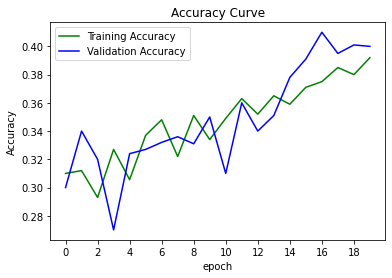

In [ ]:
import matplotlib.pyplot as plt

Train_accuracy = [0.31,0.312,0.293,0.327,0.3056,0.337,0.348,0.322,0.351,0.334,0.349,0.363,0.352,0.365,0.359,0.371,0.375,0.385,0.38,0.392]
Valid_accuracy = [0.30,0.34,0.32,0.27,0.324,0.327,0.332,0.336,0.331,0.35,0.31,0.36,0.34,0.351,0.378,0.391,0.41,0.395,0.401,0.40]

epochs = np.arange(0, 20)
plt.plot(epochs, Train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, Valid_accuracy, 'b', label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(0,20,2))
#plt.savefig('Accuracy_Curve.png')
plt.show()
plt.close()

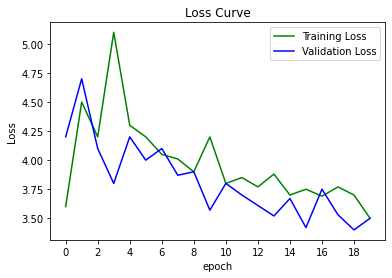

In [ ]:
import numpy as np

Train_loss = [3.6,4.5,4.2,5.1,4.3,4.2,4.05,4.01,3.9,4.2,3.8,3.85,3.77,3.88,3.7,3.75,3.69,3.77,3.7,3.5]
Valid_loss = [4.2,4.7,4.1,3.8,4.2,4.0,4.1,3.87,3.9,3.57,3.8,3.7,3.61,3.52,3.67,3.42,3.75,3.53,3.4,3.5]

epochs = np.arange(0, 20)
plt.plot(epochs, Train_loss, 'g', label='Training Loss')
plt.plot(epochs, Valid_loss, 'b', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.xticks(range(0,20,2))
plt.legend()
#plt.savefig('Accuracy_Curve.png')
plt.show()
plt.close()

In [ ]:
For example, a 256*256 gray image, there are 65536 pixels, and each pixel need to pick one color within 313 options. 

65536